In [1]:
# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

In [2]:
# Load ESOL solubility dataset from DeepChem
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url)

# Rename target column for clarity
df = df.rename(columns={"measured log solubility in mols per litre": "Solubility"})

# Show first few rows
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,Solubility,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [3]:
# Molecular descriptors using RDKit

# Get all descriptor names from RDKit
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# Function to featurize a SMILES string
def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return list(calculator.CalcDescriptors(mol))

# Apply featurization and remove invalid SMILES
df['features'] = df['smiles'].apply(featurize)
df = df[df['features'].notnull()]

# Convert feature list into a NumPy array
X = np.array(df['features'].tolist())
y = df['Solubility']

# Confirm shape
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (1128, 208)


In [4]:
# Split dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 902
Test set size: 226


In [5]:
# Train the XGBoost regression model

model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

R² Score: 0.899
RMSE: 0.691


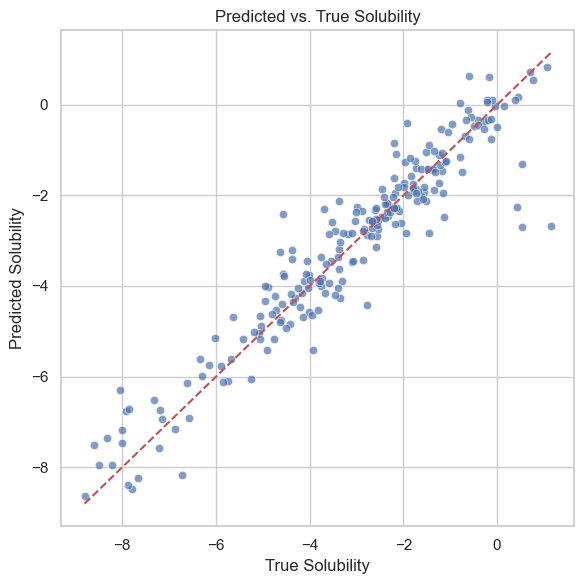

In [6]:
# Evaluate model performance

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Scatter plot of predictions vs. true values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Predicted vs. True Solubility")
plt.tight_layout()
plt.show()

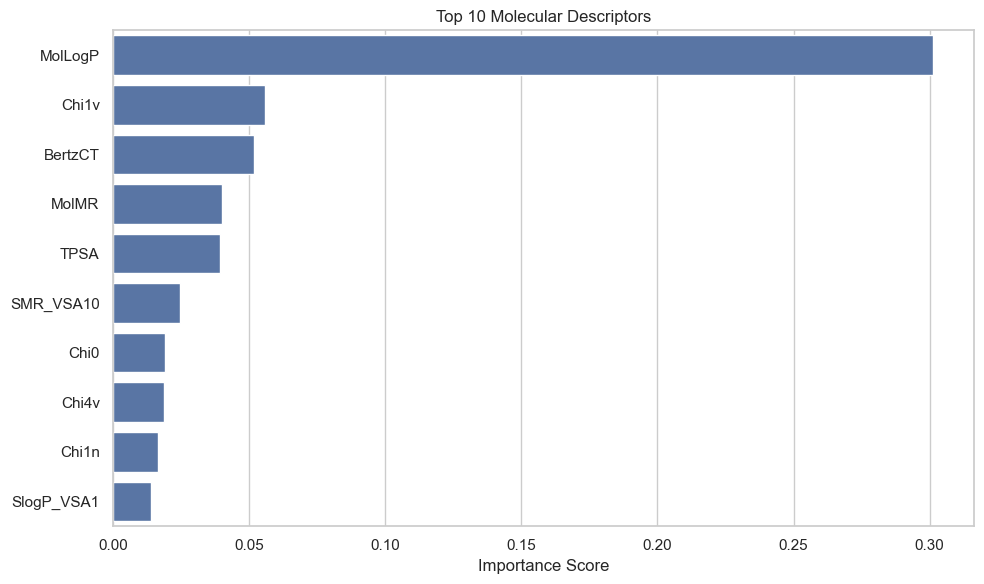

In [7]:
# Feature importance plot (Top 10 descriptors)

# Get feature importances from the trained model
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get top 10
top_n = 10
top_features = np.array(descriptor_names)[indices[:top_n]]
top_importances = importances[indices[:top_n]]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, orient='h')
plt.xlabel("Importance Score")
plt.title("Top 10 Molecular Descriptors")
plt.tight_layout()
plt.show()

In [8]:
# 5-Fold Cross-Validation for model robustness

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.3f}")

5-Fold CV R² Scores: [0.92407378 0.9221309  0.92527434 0.91230543 0.87605698]
Average CV R²: 0.912


In [9]:
import joblib

joblib.dump(model, "qsar_model.pkl")
joblib.dump(descriptor_names, "descriptor_names.pkl")

print("Model and descriptor names saved.")

Model and descriptor names saved.
